<a href="https://colab.research.google.com/github/danjethh/audio_forensics/blob/main/audio_forensic_using_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Load and Display Dataset Details


### **Purpose:**  
Show that the dataset is made up of rows, where each row contains numerical measurements (features) that describe one untampered (clean) audio recording.

### **Input:**  
- A GitHub link to the dataset file (in `.csv.xls` format).


### **Output:**  
- Displays the first 10 rows of the dataset as a table.
- Shows all column names, each representing a different audio characteristic (e.g., pitch, duration, sample rate).


In [3]:
# Step 1: Load and Display Dataset Details
def load_audio_dataset():
    import pandas as pd

    # GitHub raw link to the dataset
    url = "https://raw.githubusercontent.com/danjethh/audio_forensics/main/Values.csv"

    # Load the dataset
    df = pd.read_csv(url, encoding='latin1', engine='python', on_bad_lines='skip')

    # Print dataset info
    print("Dataset loaded successfully.")
    print(f"Total rows: {df.shape[0]}")
    print(f"Total columns: {df.shape[1]}")
    print("\nFirst 10 rows:")

    display(df.head(10))

    return df

# Call the function
df = load_audio_dataset()


Dataset loaded successfully.
Total rows: 614
Total columns: 27

First 10 rows:


,File Name,Duration (ss),Fundamental Frequency (Hz),Mean Pitch (Hz),Pitch Sigma (Hz),Minimum Pitch (Hz),Maximum Pitch (Hz),No. of Pulses,No. of periods,Mean Period (ss),...,Peak Amplitude Channel 1 (dB),Peak Amplitude Channel 2 (dB),Bit Rate (kbs),Sample Rate (Hz),Resolution (bits),No of Samples,Size on memory (kB),Size on disk (MB),Channels,Source
0,speaker1_00,60.030000,155.449136,155.449,40.954,76.401,595.867,4458,4319,6.46E-03,...,-2.08,-7.02,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
1,speaker1_01,60.030000,148.55562,148.556,34.376,78.64,581.55,4030,3914,6.73E-03,...,-4.6,-10.31,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
2,speaker1_02,60.030000,145.306523,145.307,38.117,74.808,553.119,4024,3893,6.91E-03,...,-3.65,-7.97,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
3,speaker1_03,60.030000,147.912099,147.912,36.828,68.095,589.918,4116,3994,6.79E-03,...,-5.65,-7.96,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
4,speaker1_04,60.030000,150.163581,150.164,35.449,77.557,557.195,3624,3507,6.68E-03,...,-3.26,-6.45,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
5,speaker1_05,60.034979,147.447288,147.447,42.173,69.238,559.534,4018,3903,6.82E-03,...,-4.98,-9.2,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
6,speaker1_06,60.034979,138.428902,138.429,37.552,76.718,596.054,3647,3525,7.26E-03,...,-5.03,-6.23,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
7,speaker1_07,60.034979,128.484654,128.485,26.264,78.682,411.371,3691,3572,7.81E-03,...,-6.08,-8.62,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
8,speaker1_08,60.034979,143.929268,143.929,43.185,75.88,596.639,3711,3575,6.98E-03,...,-4.61,-6.45,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
9,speaker1_09,60.034979,136.31225,136.312,43.315,76.46,585.347,3845,3718,7.38E-03,...,-7.73,-8.52,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi


## Step 2: Clean Dataset and Select Relevant Features

---

### **Purpose:**  
Keep only the features needed for this project and prepare the data for model training.



### **Input:**  
- The dataset loaded in Step 1.



### **Output:**  
- A cleaned table containing only `Duration (ss)` and `Sample Rate (Hz) columns`.
- A saved file named `cleaned_audio_dataset.csv`.
- Displays the first 10 rows of the cleaned data.


In [4]:
def clean_and_select_features(df):
    import pandas as pd

    # Select only the features also extractable using librosa
    target_columns = [
        "Duration (ss)",
        "Sample Rate (Hz)"
    ]

    # Filter only those columns
    df_clean = df[target_columns].copy()

    # Convert to numeric (if needed)
    df_clean = df_clean.apply(pd.to_numeric, errors='coerce')

    # Show NaN info before dropping rows
    print("Missing values per column before dropping rows:")
    print(df_clean.isna().sum())

    # Drop any rows with missing values
    df_clean = df_clean.dropna()

    # Save cleaned dataset
    df_clean.to_csv("cleaned_audio_dataset.csv", index=False)

    # Summary
    print("\nData cleaned and saved as 'cleaned_audio_dataset.csv'")
    print(f"Rows retained: {df_clean.shape[0]}")
    print(f"Columns retained: {df_clean.shape[1]}")
    display(df_clean.head(10))

    return df_clean

# Call the function
df_features = clean_and_select_features(df)


Missing values per column before dropping rows:
Duration (ss)       0
Sample Rate (Hz)    0
dtype: int64

Data cleaned and saved as 'cleaned_audio_dataset.csv'
Rows retained: 614
Columns retained: 2


,Duration (ss),Sample Rate (Hz)
0,60.030000,48000
1,60.030000,48000
2,60.030000,48000
3,60.030000,48000
4,60.030000,48000
5,60.034979,48000
6,60.034979,48000
7,60.034979,48000
8,60.034979,48000
9,60.034979,48000


## Step 3: Train Isolation Forest Model

---

### **Purpose:**  
Use the cleaned dataset to train an Isolation Forest model that can learn the normal pattern of untampered audio files.


### **Input:**  
- A table containing only `Duration (ss)` and `Sample Rate (Hz)` for each audio file.


### **Output:**  
- A trained Isolation Forest model.
- A table showing each audio file's anomaly status (`1` for normal, `-1` for outlier).
- Displays the first 10 prediction results.


In [8]:
# Step 3 Function: Train Isolation Forest on Cleaned Audio Dataset (2 Features)
def train_isolation_forest_on_normal_data(df_features):
    from sklearn.ensemble import IsolationForest

    # Initialize the Isolation Forest model
    model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

    # Train the model using the two-feature dataset
    model.fit(df_features)

    # Predict anomaly status on the same dataset (optional: baseline test)
    predictions = model.predict(df_features)

    # Add predictions as a new column
    df_results = df_features.copy()
    df_results["Anomaly"] = predictions

    # Count the number of statistical outliers detected
    anomaly_count = (df_results["Anomaly"] == -1).sum()

    # Display results
    print("Isolation Forest model trained using Duration and Sample Rate only.")
    print(f"Total rows in training set: {df_results.shape[0]}")
    print(f"Number of predicted anomalies (outliers): {anomaly_count}")
    display(df_results.head(10))

    return model, df_results

# Call the function
model, df_results = train_isolation_forest_on_normal_data(df_features)


Isolation Forest model trained using Duration and Sample Rate only.
Total rows in training set: 614
Number of predicted anomalies (outliers): 183


,Duration (ss),Sample Rate (Hz),Anomaly
0,60.030000,48000,1
1,60.030000,48000,1
2,60.030000,48000,1
3,60.030000,48000,1
4,60.030000,48000,1
5,60.034979,48000,1
6,60.034979,48000,1
7,60.034979,48000,1
8,60.034979,48000,1
9,60.034979,48000,1


## Step 4: Save Model and Visualize Prediction Results

---

### **Purpose:**  
Save the trained model for later use.



### **Input:**  
- The trained Isolation Forest model.
- The prediction results from Step 3.



### **Output:**  
- A saved model file named `audio_isolation_forest_model.pkl`.
- A bar chart showing how many audio files were labeled as normal (`1`) or anomalous (`-1`).


Model saved as 'audio_isolation_forest_model.pkl'.


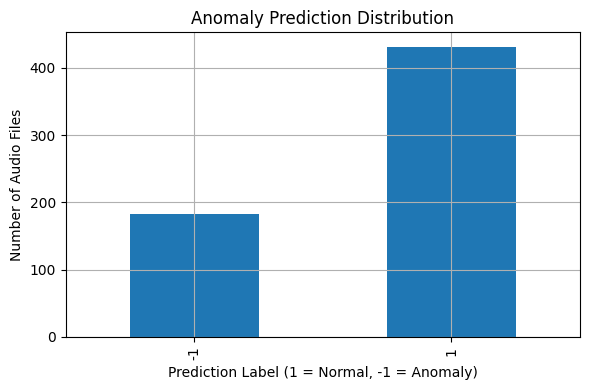

In [9]:
# Step 4 Function: Save the trained model and visualize anomaly prediction distribution
def save_model_and_plot_anomaly_distribution(model, df_results):
    import joblib
    import matplotlib.pyplot as plt

    # Save the model as a .pkl file
    joblib.dump(model, "audio_isolation_forest_model.pkl")
    print("Model saved as 'audio_isolation_forest_model.pkl'.")

    # Visualize prediction distribution
    anomaly_counts = df_results["Anomaly"].value_counts().sort_index()

    plt.figure(figsize=(6, 4))
    anomaly_counts.plot(kind='bar')
    plt.title("Anomaly Prediction Distribution")
    plt.xlabel("Prediction Label (1 = Normal, -1 = Anomaly)")
    plt.ylabel("Number of Audio Files")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Call the function
save_model_and_plot_anomaly_distribution(model, df_results)


## Step 5: Extract Features from Suspicious Audio File

---

###  **Purpose:**  
Get the same features (Duration and Sample Rate) from a suspicious audio file to prepare it for prediction.


###  **Input:**  
- A direct GitHub raw link to a `.wav` audio file.


###  **Output:**  
- A table with two values:
  - `Duration (ss)`
  - `Sample Rate (Hz)`


In [10]:
# Step 5: Load audio from GitHub and extract matching features only
def extract_features_from_github_audio(github_raw_audio_url):
    import librosa
    import numpy as np
    import pandas as pd
    import urllib.request
    import os

    # Temporary filename
    local_filename = "temp_audio.wav"

    # Download the audio file
    urllib.request.urlretrieve(github_raw_audio_url, local_filename)

    # Load audio
    y, sr = librosa.load(local_filename, sr=None)

    # Extract only the features used during model training
    features = {
        "Duration (ss)": librosa.get_duration(y=y, sr=sr),
        "Sample Rate (Hz)": sr
    }

    # Create a DataFrame
    df_input = pd.DataFrame([features])

    print("Extracted features (Duration and Sample Rate) from GitHub-hosted audio file:")
    display(df_input)

    # Clean up
    os.remove(local_filename)

    return df_input

# Example usage
github_audio_url = "https://github.com/pdx-cs-sound/wavs/raw/main/car-horn.wav"
new_audio_features = extract_features_from_github_audio(github_audio_url)


Extracted features (Duration and Sample Rate) from GitHub-hosted audio file:


,Duration (ss),Sample Rate (Hz)
0,5.891583,48000


## Step 6: Predict if the Audio is Anomalous

---

### **Purpose:**  
Use the trained model to decide if the uploaded audio file looks suspicious or untampered.



### **Input:**  
- A table containing `Duration (ss)` and `Sample Rate (Hz)` from the audio file.
- The saved model file from Step 4.



### **Output:**  
- A table with the extracted features and a new column called `Anomaly`.
  - `1` = normal
  - `-1` = anomalous
- A printed message explaining the result in plain language.


In [11]:
# Step 7: Use Saved Model to Predict if Uploaded Audio is Anomalous
def score_extracted_audio_features(model_path, extracted_features_df):
    import joblib

    # Load the saved Isolation Forest model
    model = joblib.load(model_path)

    # Predict anomaly status
    prediction = model.predict(extracted_features_df)

    # Add prediction result
    result = extracted_features_df.copy()
    result["Anomaly"] = prediction

    # Display results
    print("Prediction result for the uploaded audio:")
    display(result)

    # Print interpretation
    if prediction[0] == -1:
        print("The model flagged this audio as ANOMALOUS (possibly tampered).")
    else:
        print("The model flagged this audio as NORMAL (no anomalies detected).")

    return result

# Call the function with the extracted features
final_prediction = score_extracted_audio_features(
    model_path="audio_isolation_forest_model.pkl",
    extracted_features_df=new_audio_features
)


Prediction result for the uploaded audio:


,Duration (ss),Sample Rate (Hz),Anomaly
0,5.891583,48000,-1


The model flagged this audio as ANOMALOUS (possibly tampered).
